In [1]:
import torch
import torch.nn as nn
from torch.nn import *
import torch.nn.functional as F
from torchvision.models import resnet18
from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10
import numpy as np
import sys; sys.path.append('..')
from mine import MINE
import matplotlib.pyplot as plt

In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean = 0., std = 1.):
        self.std = std
        self.mean = mean
    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size())*self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + f'Mean = {self.mean}, Std = {self.std}'

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18()
        self.logits = nn.Linear(1000, 10)
        self.mlp = nn.Sequential(
            nn.Linear(20, 100),
            nn.ELU(),
            nn.Linear(100, 1024),
            nn.ELU(),
            nn.Linear(1024, 2048),
            nn.ELU(),
            nn.Linear(2048, 1024),
            nn.ELU(),
            nn.Linear(1024, 256),
            nn.ELU(),
            nn.Linear(256, 64),
            nn.ELU(),
            nn.Linear(64, 8),
            nn.ELU(),
            nn.Linear(8, 1)
        )

    def forward(self, x, y):
        x = self.resnet(x)
        x = self.logits(x)
        fused = torch.cat((x, y), dim = 1)
        out = self.mlp(fused)
        return out

In [4]:
noise_levels = 10.0**np.linspace(-2, 3, 10)
mi_values = []
for noise_level in noise_levels:
    print(f'Noise level: {noise_level}')
    transform = transforms.Compose([
        transforms.ToTensor(),
        AddGaussianNoise(0., noise_level),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    target_transform = transforms.Compose([
        lambda x: torch.tensor(x),
        lambda x: F.one_hot(x, num_classes = 10)
    ])

    batch_size = 512

    trainset = CIFAR10(root = '~/datasets', train = True, transform = transform, target_transform = target_transform)
    
    epochs = 25
    mine = MINE(Net, trainset)
    mine_estimator, bounds, joint_scores, product_scores = mine.optimize(epochs = epochs, verbose = False)
    mine_estimate = mine.estimate()
    mi_values.append(mine_estimate)

Noise level: 0.01
Noise level: 0.03593813663804627
Noise level: 0.1291549665014884
Noise level: 0.464158883361278
Noise level: 1.668100537200059
Noise level: 5.994842503189409
Noise level: 21.544346900318843
Noise level: 77.42636826811277
Noise level: 278.25594022071255
Noise level: 1000.0


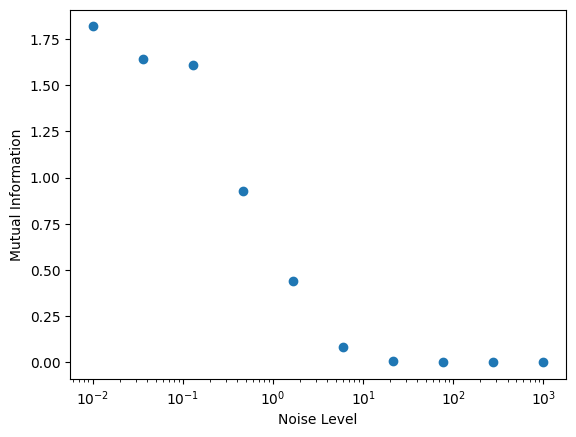

In [5]:
plt.scatter(noise_levels, mi_values)
plt.xscale('log')
plt.xlabel('Noise Level')
plt.ylabel('Mutual Information')
plt.show()